In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [27]:
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor
)

class BaseRandomForest(object):

    def __init__(self, n_estimators=10, max_depth=None):
        self._n_estimators = n_estimators
        self._max_depth = max_depth
        self._estimators = []

    def _create_tree(self):
        raise NotImplementedError()

    def _all_predictions(self, X):
        return [estimator.predict(X) for estimator in self._estimators]

    def fit(self, X, y):
        samples = len(y)
        X = np.asarray(X)
        y = np.asarray(y)

        for _ in range(self._n_estimators):
            sample_indices = np.random.randint(0, samples, samples)
            train_X = X[sample_indices, :]
            train_y = y[sample_indices]
            estimator = self._create_tree().fit(train_X, train_y)
            self._estimators.append(estimator)

        return self

    def predict(self, X):
        raise NotImplementedError()


class RandomForestRegressor(BaseRandomForest):

    def _create_tree(self):
        return DecisionTreeRegressor(
            max_depth=self._max_depth,
            max_features='sqrt'
        )

    def predict(self, X):
        return np.mean(self._all_predictions(X), axis=0)


class RandomForestClassifier(BaseRandomForest):

    def _create_tree(self):
        return DecisionTreeClassifier(
            max_depth=self._max_depth,
            max_features='sqrt'
        )

    def predict(self, X):
        return np.argmax(np.bincount(self._all_predictions(X)))

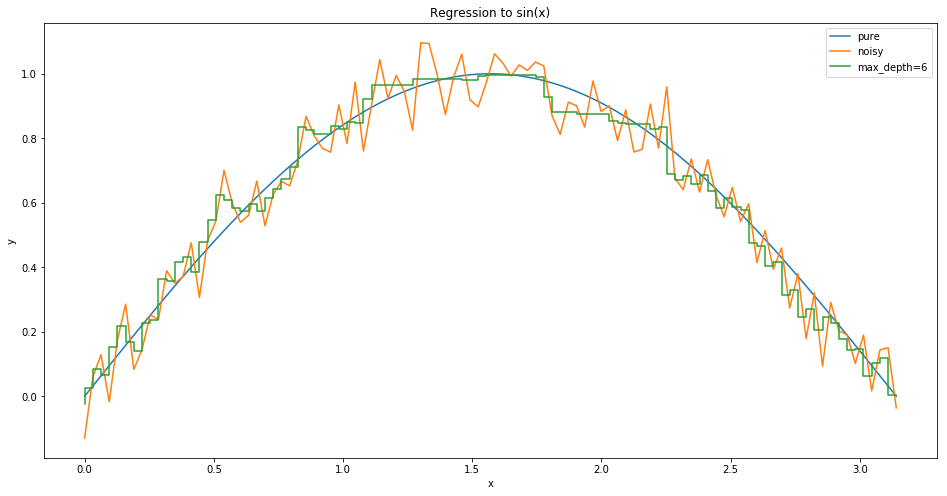

In [36]:
X = np.linspace(0, np.pi, 100).reshape(-1, 1)
y_pure = np.sin(X)
y_noisy = y_pure + np.random.normal(0, 0.07, X.shape)

fig, ax = plt.subplots()
ax.plot(X, y_pure, label='pure')
ax.plot(X, y_noisy, label='noisy')

max_depth = 6
y_predicted = RandomForestRegressor(max_depth=max_depth, n_estimators=20).fit(X, y_noisy).predict(X)
ax.step(X, y_predicted, label='max_depth={}'.format(max_depth))

ax.legend()
ax.set(
    xlabel='x',
    ylabel='y',
    title='Regression to sin(x)'
)
fig.set_size_inches(w=16, h=8)